In [1]:
import torch
import time
import datasets
import torch.nn as nn
import wandb
import os
import json
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

from imgaug import augmenters
from PIL import Image
from transformers import TrainingArguments,Trainer, ViTForImageClassification,ViTConfig
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as F
from datasets import load_dataset
import torchvision.transforms as transforms
from torchvision import transforms
%matplotlib inline

In [2]:
images_path = "images"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
with open("config.json", "r") as f:
    config_dict = json.load(f)
with open("images/info.json", 'r', encoding='utf-8') as file:
    categories = json.loads(file.read())['categories']

In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df 

,id,target
0,gL5fWrgNPU.jpg,0
1,KKWXJDN8uM.png,1
2,Wb2I0CXlAY.jpg,0
3,G7PLhKpaf7.jpeg,1
4,DEUkeefz6Z.jpg,0
...,...,...
1007,fqoVycdxLV,1
1008,TN2ZOiNI5e.jpg,0
1009,2WMWt6CAWQ.jpg,0
1010,fQCY5n2vcF.jpg,0


In [6]:
test_df 

,id
0,Qt1fGUB0Vz.jpeg
1,j4Rhioq7R3.jpeg
2,rD0hgFHJUZ.jpeg
3,aY5z1EJsJ6.jpeg
4,qZ3IoxD2TE.jpeg
...,...
501,Qrme6EUmL1
502,4369Dl8wfs.jpeg
503,BrNEvRNpPu.jpeg
504,DuwXCNmeMx.webp


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1012 non-null   object
 1   target  1012 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.9+ KB


In [8]:
train_df.isnull().values.any()

False

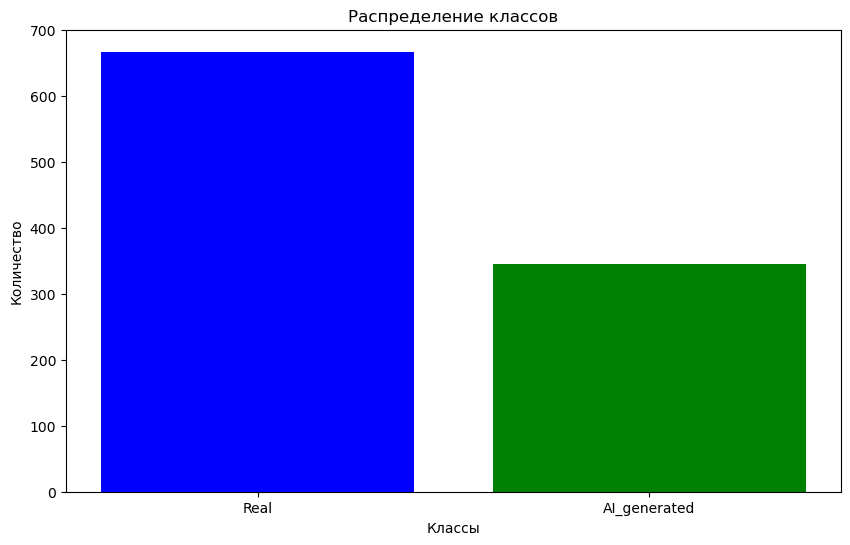

In [9]:
class_counts = train_df['target'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'green'])
plt.title('Распределение классов')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.xticks(class_counts.index, ['Real', 'AI_generated'])
plt.show()

In [16]:
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/train/real", exist_ok=True)
os.makedirs("data/train/ai", exist_ok=True)

os.makedirs("data/val", exist_ok=True)
os.makedirs("data/val/real", exist_ok=True)
os.makedirs("data/val/ai", exist_ok=True)

In [17]:
unsplited_train_files = [file for file in train_df["id"]]

In [18]:
train_files, val_files = train_test_split(unsplited_train_files, test_size=0.2, random_state=42)

In [19]:
for image_file in train_files:
    if '.' not in image_file:
        image = image_file + ".png"
    else:
        image = image_file
    source_path = os.path.join("images", image)
    if train_df.loc[train_df['id'] == image_file, 'target'].values == 0:
        new_path =os.path.join("data","train", "real", image)
    else: 
        new_path =os.path.join("data","train", "ai", image)
    shutil.copy2(source_path, new_path)
    
for image_file in val_files:
    if '.' not in image_file:
        image = image_file + ".png"
    else:
        image = image_file
    source_path = os.path.join("images", image)
    if train_df.loc[train_df['id'] == image_file, 'target'].values == 0:
        new_path =os.path.join("data","val", "real", image)
    else: 
        new_path =os.path.join("data","val", "ai", image)
    shutil.copy2(source_path, new_path)

l0xpKY1T0C.jpg [0]
pNKX256vBV.jpg [0]
TuOgaJkenX.jpg [0]
4A2ONNIbwV.jpg [0]
XzXIEkjV8O.jpg [0]
Oh3wLH8WlE.jpeg [1]
vJnYLa7uzC.jpg [0]
FAAdmGG4mu.jpg [0]
mMtnFWnHqV.png []
3SzvQ6t05E.jpg [0]
yzvnxkrzQr.jpg [0]
ZurgHMoqmt.jpg [0]
nLR26mBEaO.jpg [0]
7RN02zxfpW.jpeg [1]
PBq2zBnyUO.jpeg [1]
COOgbwqwai.jpg [0]
CDfxQRTDyR.jpeg [1]
FwT2xNHKUS.jpg [0]
h9j4Oc7vec.jpeg [1]
RGqtcrfndS.jpg [0]
YylDFQDS2Z.jpg [0]
exoYLWJiSX.jpg [0]
VNt5dGy0N4.png []
4N2MbadieU.jpg [0]
Ssmq7p5F7F.png []
mjLp4pk6QQ.jpg [0]
LVJka7br0Y.jpg [0]
YElcD45nqg.jpg [0]
nD9czbqX0U.jpg [0]
UypWbpyh6G.jpg [0]
7mbuYSlfnk.jpg [0]
NocroQaKBz.jpg [0]
9gDL4WuhiP.png []
wkUiWhqJyO.jpg [0]
VtDKOGtgdf.jpg [0]
hC57WI2b5h.jpg [0]
KcBuDaKBp9.png []
MWapNx0vq4.jpg [0]
zzOWcilH1B.jpg [0]
gQ3jhTWAi4.png []
WeXQa3x0RV.jpg [0]
wDFR4zzxDn.jpeg [1]
3YMwaR2miM.jpeg [1]
WRNIGbD9gL.jpg [0]
VQ7b5VWu6d.png []
5OLEMF4MKK.jpg [0]
Dr83SgH2lg.jpg [0]
Z6Eg0yXNzB.jpg [0]
obsPopKS20.jpg [0]
M4iETy4TVv.jpg [0]
m9GlU31a6C.jpg [0]
nkdvHPFagq.jpg [0]
Zv9n5TUHgn.j

In [20]:
configuration = ViTConfig(**config_dict)
model = ViTForImageClassification(configuration)
model.config

ViTConfig {
  "_name_or_path": "dima806/ai_vs_real_image_detection",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "real",
    "1": "ai"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "ai": "1",
    "real": "0"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "single_label_classification",
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.37.2"
}

In [21]:
model = ViTForImageClassification.from_pretrained("dima806/ai_vs_real_image_detection", num_labels=2)
model = model.to(device)
model.train()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [22]:
dataset = load_dataset('imagefolder', data_dir= 'data')
labels = dataset['train'].features['label'].names

Resolving data files:   0%|          | 0/1618 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/406 [00:00<?, ?it/s]

2024-03-31 22:29:04,956 datasets.builder [WARNING] - Found cached dataset imagefolder (C:/Users/user/.cache/huggingface/datasets/imagefolder/default-aefcca03e638fbf0/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
class VitProcessor(torch.nn.Module):
    class Letterbox:
        def __call__(self, image: Image):
            max_wh = max(image.size)
            p_left, p_top = [(max_wh - s) // 2 for s in image.size]
            p_right, p_bottom = [max_wh - (s + pad) for s, pad in zip(image.size, [p_left, p_top])]
            padding = [p_left, p_top, p_right, p_bottom]
            return F.pad(image, padding, 0, 'constant')

    def __init__(self):
        super().__init__()
        self.transforms = transforms.Compose([
            VitProcessor.Letterbox(),
            transforms.Resize(size=(224, 224),
                              interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=torch.Tensor([0.5, 0.5, 0.5]),
                                 std=torch.Tensor([0.5, 0.5, 0.5]))
        ])

    def forward(self, x):
        r, g, b = x.split()
        x = Image.merge('RGB', (b, g, r))
        return self.transforms(x)

In [24]:
processor = VitProcessor()

In [25]:
def augment(image: Image) -> Image:
            transforms = augmenters.Sequential([
                augmenters.Add((-40, 40)),
                augmenters.AdditiveGaussianNoise(scale=(0, 0.2 * 255)),
                augmenters.JpegCompression(compression=(0, 60)),
                augmenters.GaussianBlur(sigma=(0.0, 1.0)),
                augmenters.GammaContrast((0.5, 2.0)),
                augmenters.PerspectiveTransform(scale=(0.01, 0.15))
            ])
            if image.mode == 'P' or image.mode == 'L':    
                image = image.convert('RGB')
            if image.mode == 'RGBA':
                background = Image.new('RGB', image.size, (224, 224, 224))
                background.paste(image, mask=image.split()[3])  
                image = background
            image = np.array(image)
            image = transforms(images=[image])[0]
            image = Image.fromarray(image.astype('uint8'), 'RGB')
            return image

In [26]:
def convert_labels(batch_label):
            category = dataset['train'].features['label'].names[batch_label]
            return categories.index(category)

In [27]:
def train_transform(batch):
    inputs = {'pixel_values': [processor(augment(image)) for image in batch['image']],
              'labels': [convert_labels(label) for label in batch['label']]}
    return inputs

In [28]:
def transform(batch):
    inputs = {
        'pixel_values': [processor(image) for image in batch['image']],
        'labels': [convert_labels(label) for label in batch['label']]
    }
    return inputs

In [29]:
dataset = dataset.with_transform(train_transform)

In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1618
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 406
    })
})

In [31]:
metric = datasets.load_metric('accuracy')

C:\Users\user\AppData\Local\Temp\ipykernel_2208\4140158948.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('accuracy')


In [32]:
def collate_fn(batch):
            return {
                'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
                'labels': torch.tensor([x['labels'] for x in batch])
            }

In [33]:
def compute_metrics(output):
            return metric.compute(
                predictions=np.argmax(output.predictions, axis=1),
                references=output.label_ids
            )

In [34]:
model_checkpoints_dir = "saved_model"

In [35]:
training_args = TrainingArguments(
    output_dir= './results/vit_dima_with_val',
    per_device_train_batch_size=128,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    fp16=True,
    logging_steps=1,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    report_to=['wandb']
)

In [36]:
trainer = Trainer(
            model=model.to(device),
            args=training_args,
            data_collator=collate_fn,
            compute_metrics=compute_metrics,
            train_dataset=dataset['train'],
            eval_dataset=dataset['validation']
        )

In [37]:
train_results = trainer.train()
trainer.save_model()     

wandb: Currently logged in as: kikkoshelev (my_teamdd). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.087400,0.083044,0.967980
2,0.014000,0.059962,0.980296
3,0.015000,0.064359,0.972906


In [39]:
trainer.log_metrics('train', train_results.metrics)
trainer.save_metrics('train', train_results.metrics)
trainer.save_state()
metrics = trainer.evaluate(dataset['validation'])

***** train metrics *****
  epoch                    =         3.0
  total_flos               = 350313370GF
  train_loss               =      0.1629
  train_runtime            =  0:08:24.15
  train_samples_per_second =       9.628
  train_steps_per_second   =       0.077


In [40]:
trainer.log_metrics('eval', metrics)
trainer.save_metrics('eval', metrics)   

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9729
  eval_loss               =     0.0675
  eval_runtime            = 0:00:19.59
  eval_samples_per_second =     20.716
  eval_steps_per_second   =      2.602


In [41]:
test_paths = []
for image in test_df["id"]:
    if '.' not in image:
        image += ".png"
    test_paths.append("images/" + image)
    
test_names = [image for image in test_df["id"]]

In [42]:
class TestVitProcessor(torch.nn.Module):
    class Letterbox:
        def __call__(self, image: Image):
            max_wh = max(image.size)
            p_left, p_top = [(max_wh - s) // 2 for s in image.size]
            p_right, p_bottom = [max_wh - (s + pad) for s, pad in zip(image.size, [p_left, p_top])]
            padding = [p_left, p_top, p_right, p_bottom]
            return F.pad(image, padding, 0, 'constant')

    def __init__(self):
        super().__init__()
        #self.settings = Settings.get_instance()
        self.transforms = transforms.Compose([
            VitProcessor.Letterbox(),
            transforms.Resize(size=(224, 224),
                              interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=torch.Tensor([0.5, 0.5, 0.5]),
                                 std=torch.Tensor([0.5, 0.5, 0.5]))
        ])

    def forward(self, x):
        if x.mode == 'RGBA':
            background = Image.new('RGB', x.size, (224, 224, 224))
            background.paste(x, mask=x.split()[3])  
            x = background
        r, g, b = x.split()
        x = Image.merge('RGB', (b, g, r))
        return self.transforms(x)

In [43]:
test_processor = TestVitProcessor()

In [44]:
test_inputs = [test_processor(Image.open(img_path)) for img_path in test_paths]

In [45]:
model.eval()
with torch.no_grad():
    predictions = []
    for inputs in test_inputs:
        inputs = inputs.to(device)
        outputs = model(inputs.unsqueeze(0))  # Добавляем размер батча
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        predictions.append(probs.cpu())


for i, pred in enumerate(predictions):
    print(f"Предсказания для изображения {test_paths[i]}: {pred}")

Предсказания для изображения images/Qt1fGUB0Vz.jpeg: tensor([[0.9962, 0.0038]])
Предсказания для изображения images/j4Rhioq7R3.jpeg: tensor([[0.7821, 0.2179]])
Предсказания для изображения images/rD0hgFHJUZ.jpeg: tensor([[0.9961, 0.0039]])
Предсказания для изображения images/aY5z1EJsJ6.jpeg: tensor([[0.0029, 0.9971]])
Предсказания для изображения images/qZ3IoxD2TE.jpeg: tensor([[0.9522, 0.0478]])
Предсказания для изображения images/BOFtxEERkV.jpeg: tensor([[0.9929, 0.0071]])
Предсказания для изображения images/9hqOXpYGbK.jpeg: tensor([[0.9866, 0.0134]])
Предсказания для изображения images/BhA8T8Ij32.jpeg: tensor([[0.9804, 0.0196]])
Предсказания для изображения images/rXexUH9dCM.jpeg: tensor([[0.9848, 0.0152]])
Предсказания для изображения images/RdYDVBxwvq.jpeg: tensor([[0.0098, 0.9902]])
Предсказания для изображения images/8iV3hx6XAj.jpeg: tensor([[0.9972, 0.0028]])
Предсказания для изображения images/aleXj7h7JP.jpeg: tensor([[0.9892, 0.0108]])
Предсказания для изображения images/RVoq

In [46]:
probs_for_ai = [pred.tolist()[0][1] for pred in predictions]

In [47]:
probs_for_ai

[0.003824483836069703,
 0.2179194688796997,
 0.0038844766095280647,
 0.9970991611480713,
 0.04778006672859192,
 0.007052709814161062,
 0.013350849971175194,
 0.019606182351708412,
 0.015247589908540249,
 0.9901971817016602,
 0.0027737829368561506,
 0.010818447917699814,
 0.01083937007933855,
 0.025834187865257263,
 0.9961456060409546,
 0.00307536986656487,
 0.9906056523323059,
 0.9879695177078247,
 0.0065388246439397335,
 0.10511863231658936,
 0.01634012721478939,
 0.663396418094635,
 0.0037072531413286924,
 0.9824568033218384,
 0.9864417314529419,
 0.9833430051803589,
 0.05429894104599953,
 0.0023006375413388014,
 0.9957436919212341,
 0.9968149065971375,
 0.9948704242706299,
 0.9890130758285522,
 0.029340026900172234,
 0.9961456060409546,
 0.0032224839087575674,
 0.13039611279964447,
 0.9965097308158875,
 0.9961530566215515,
 0.0030337367206811905,
 0.003678509034216404,
 0.0030994152184575796,
 0.9976357221603394,
 0.9918437600135803,
 0.0060503981076180935,
 0.9744347929954529,
 0.0

In [48]:
predictions_df = pd.DataFrame({
    'id': test_names,
    'target': probs_for_ai,
})

predictions_df.to_csv('predictions_pretrained_with_val.csv', index=False)